In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set seed
torch.manual_seed(42)
np.random.seed(42)


In [43]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from sklearn import metrics

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
# https://sebastiancallh.github.io/post/affine-normalizing-flows/
# uses Real NVP paper

# Define the Normalizing Flow model template
class NormalizingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) #zeros?
        
        # takes the number of samples and returns a tensor of ones with the same size
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)


class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x)
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)


class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int, num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),  # Add BatchNorm layer
            nn.LeakyReLU(inplace=True)  # Add ReLU activation
        )
        self.hidden = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                #nn.BatchNorm1d(hidden_dim),  # Add BatchNorm layer
                nn.LeakyReLU(inplace=True)  # Add ReLU activation
            )
            for _ in range(num_hidden)
        ])

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        # self.dims = nn.Sequential(
        #     nn.Linear(hidden_dim, out_dim * num_params),
        #     nn.BatchNorm1d(out_dim * num_params),  # Add BatchNorm layer
        #     nn.Tanh()  # You can use Tanh or another appropriate activation here
        # )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input(x)
        for h in self.hidden:
            x = h(x)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        batch_params[:,:,1] *= 0.001
        batch_params[:,:,0] *= 0.001
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        super(CNN, self).__init__()
        # input: 3 x 32 x 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) 
        # kernel size is 3x3 with padding 1, so the output size is the same as the input size 
        # 32-3+2*1/1 + 1 = 32
        # we want 16 kernels (aka filters)
        # after conv1: 16 x 32 x 32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel size is 2x2 with stride 2, so the output size is half of the input size
        # after pool1: 16 x 16 x 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # kernel size is 3x3 with padding 1, so the output size is the same as the input size 
        # but double the filters (32)
        # after conv2: 32 x 16 x 16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel size is 2x2 with stride 2, so the output size is half of the input size
        # after pool2: 32 x 8 x 8
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.2)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(256, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        self.relu4 = nn.ReLU()  
        self.fc3 = nn.Linear(128, num_classes)
#adding a batch normalization after the encoder made the training
#more stable. It facilitates the match between the latent positions output by the encoder and non-zero
#density regions learned by the normalizing flows. 
        self.batchnorm3 = nn.BatchNorm1d(num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.batchnorm3(x)
        return x

def init_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        nn.init.zeros_(model.bias)

def train_flow_model(flow_model, optimiser, X_train, num_epochs, class_label):
    losses = []
    #losses = torch.zeros(num_epochs)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=1000, gamma=0.999)
    for epoch in range(num_epochs):
        optimiser.zero_grad()
        log_prob = flow_model.log_prob(X_train)
        loss = -torch.mean(log_prob)
        loss.backward()
        utils.clip_grad_norm_(flow_model.parameters(), max_norm=5.0)  # Adjust max_norm as needed
        optimiser.step()
        scheduler.step()
        #losses[epoch] = loss.item()
        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Flow model {class_label} Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')
    return losses, flow_model   



In [34]:
# Load CIFAR-10 data
data_path = './'
cifar10 =  datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

# Convert PIL images [0,1] to pytorch tensors [-1,1]
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalise pixel values by subtracting 0.5 and dividing by 0.5
    ])

batch_size = 64 # standard value
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Create a dataloader to handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_dataset.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [35]:
print("Training data")
print("Number of points:", len(train_dataset))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_dataset.targets))} (unique labels: {set(train_dataset.targets)})")

print("\nTest data")
print("Number of points:", len(test_dataset))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_dataset.targets))} (unique labels: {set(test_set.targets)})")

num_classes = len(set(test_dataset.targets))
print(f"\nNumber of classes: {num_classes}")

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Number of classes: 10


In [44]:
def image_show(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   #Unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())


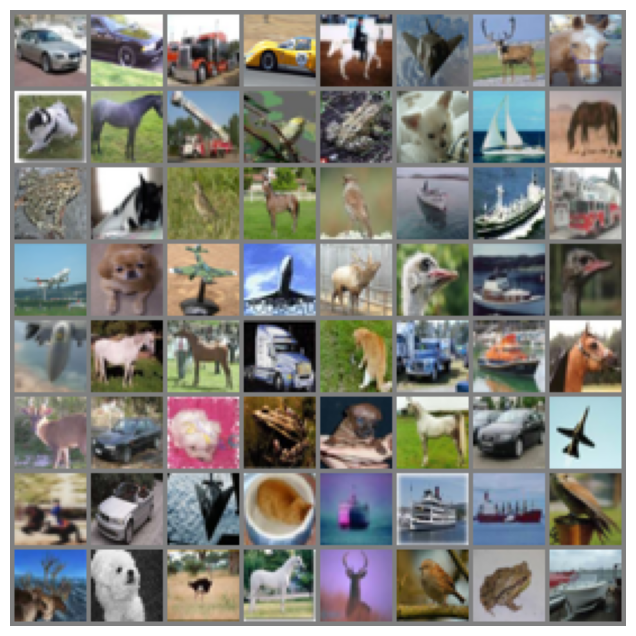

In [40]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
image_show(utils.make_grid(images))

In [50]:
def train(cnn, train_loader, test_loader, optimiser, loss_fn, num_epochs, device, validation_every_epochs=1):
    cnn.to(device)

    # Initialize lists to store training and validation accuracies
    train_accuracies = []
    valid_accuracies = []
    for epoch in range(num_epochs):
        # Initialize lists to store training accuracies for each batch
        train_accuracies_batches = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            output = cnn(inputs)
            # Compute loss
            loss = loss_fn(output, targets)

            # Perform one training step
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Compute accuracy
            predictions = output.max(1)[1]
            train_accuracies_batches.append(accuracy(targets, predictions))

        # Calculate average training accuracy for the epoch
        epoch_train_accuracy = np.mean(train_accuracies_batches)
        train_accuracies.append(epoch_train_accuracy)

        if epoch % validation_every_epochs == 0:
            # Initialize list to store validation accuracies for each batch
            valid_accuracies_batches = []

            with torch.no_grad():
                cnn.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = cnn(inputs)
                    loss = loss_fn(output, targets)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                cnn.train()

            # Calculate average validation accuracy for the epoch
            epoch_valid_accuracy = np.sum(valid_accuracies_batches) / len(test_loader.dataset)
            valid_accuracies.append(epoch_valid_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs}, "
                  f"Training Accuracy: {epoch_train_accuracy:.4f}, "
                  f"Validation Accuracy: {epoch_valid_accuracy:.4f}")

    print("Finished training.")
    return train_accuracies, valid_accuracies

In [47]:
out = cnn(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.99996626 -0.9995333   0.9995814  -0.9999732  -0.99973196 -0.9965587
   0.9998289   0.9997935   0.9999919   0.9998571 ]
 [ 0.99996626  0.9995333  -0.9995816   0.9999732   0.99973196  0.99655914
  -0.99982905 -0.9997935  -0.9999919  -0.999857  ]]
Output probabilities:
[[0.02384296 0.02385328 0.17609726 0.02384279 0.02384854 0.02392434
  0.17614084 0.17613462 0.17616956 0.17614582]
 [0.17628086 0.17620455 0.02386781 0.17628208 0.17623955 0.17568126
  0.0238619  0.02386275 0.02385802 0.02386124]]


In [52]:
num_classes = 10
cnn = CNN(num_classes).to(device)
loss_cnn = nn.CrossEntropyLoss()
optimiser_cnn = optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=1e-4)
batch_size = 64
num_epochs = 8 
# Should try 40
validation_every_steps = 500

step = 0
train_accuracies, valid_accuracies = train(cnn, train_loader, test_loader, optimiser_cnn, loss_cnn, num_epochs, device)


Epoch 1/8, Training Accuracy: 0.5515, Validation Accuracy: 0.6405
Epoch 2/8, Training Accuracy: 0.6608, Validation Accuracy: 0.6757
Epoch 3/8, Training Accuracy: 0.7068, Validation Accuracy: 0.6989
Epoch 4/8, Training Accuracy: 0.7431, Validation Accuracy: 0.7040
Epoch 5/8, Training Accuracy: 0.7689, Validation Accuracy: 0.7116
Epoch 6/8, Training Accuracy: 0.7979, Validation Accuracy: 0.7217
Epoch 7/8, Training Accuracy: 0.8238, Validation Accuracy: 0.7252
Epoch 8/8, Training Accuracy: 0.8414, Validation Accuracy: 0.7116
Finished training.


In [ ]:
# Explore feature space
def plot_latent_space(flow_model, num_samples, class_label):
    z = flow_model.latent_sample(num_samples)
    x = flow_model.g(z)
    x = x.detach().cpu().numpy()
    z = z.detach().cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.scatter(z[:, 0], z[:, 1], c=class_label, cmap='tab10', alpha=0.5)
    plt.title('Latent space')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=class_label, cmap='tab10', alpha=0.5)
    plt.title('Feature space')
    plt.show()

In [ ]:
data_dim = X_train.shape[-1] # equal 2, as is the last dimension of X_train
in_dim= 1 # data_dim // 2 # since we split the data
out_dim= 1 # data_dim // 2
num_params = 2 # s and t
num_hidden = 2 # number of hidden layers
hidden_dim = 32 # neurons in hidden layers
num_flows = 4 # number of coupling flow layers
lr = 0.0031
weight_decay = 9e-6  # L2 regularization strength to prevent overfitting in AdamW 
num_epochs = 12000  # flere epochs

#conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
# flows = [affine_coupling for _ in range(num_flows)]

# latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

# Extract features for latent space
model = CNN(num_classes).to(device)
loss_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)



flow_models = []
optimisers = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    #flow_model = NormalizingFlow(latent_distribution, flows).to(device)
    flow_model = NormalizingFlow(latent_distribution, flows).apply(init_weights).to(device)
    #optimiser = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
    optimiser = torch.optim.AdamW(flow_model.parameters(), lr=lr, weight_decay=weight_decay)
    flow_models.append(flow_model)
    optimisers.append(optimiser)

all_losses = []
flow_models_trained = []
for class_label in range(num_classes):
    print("class label",class_label)
    flow_models[class_label].apply(init_weights)
    losses, flow_model = train_flow_model(flow_models[class_label], optimisers[class_label], X_train[class_label], num_epochs, class_label)
    all_losses.append(losses)
    flow_models_trained.append(flow_model)
all_losses = np.array(all_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(all_losses[0,10:])
axes[0].set_title("Losses class 0")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].plot(all_losses[1,10:])
axes[1].set_title("Losses class 1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
plt.tight_layout()
plt.show()

X_train = X_train.cpu().numpy()

In [ ]:
print("Final loss class 0: ", all_losses[0,-1])
print("Final loss class 1: ", all_losses[1,-1])

In [ ]:
# Generate samples from the trained models
num_samples_gen_per_class = 500
generated_samples = []
with torch.no_grad():
    for class_label in range(num_classes):
        samples = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()
        generated_samples.append(samples)
generated_samples = np.array(generated_samples)
print("Generated samples shape: ", generated_samples.shape)

In [ ]:
# Check if class 0 from generated samples is different from class 1 in generated samples
# colors = ['r', 'b']
# plt.figure(figsize=(8, 6))
# for class_label in range(num_classes):
#     plt.scatter(generated_samples[class_label][:, 0], generated_samples[class_label][:, 1], 
#                 color=colors[class_label], alpha = 0.7, label=f'Generated Class {class_label}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.title('Generated Samples for Class 0 and Class 1')
# plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot Class 0
axes[0].scatter(X_train[0, :, 0], X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
axes[0].scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.6, label='Generated Class 0')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Class 0 vs. Generated Class 0')
axes[0].legend()

# Plot Class 1
axes[1].scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
axes[1].scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='g', alpha=0.6, label='Generated Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Class 1 vs. Generated Class 1')
axes[1].legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[0, :, 0],X_train[0, :, 1], color='r', alpha=0.6, label='Class 0')
plt.scatter(generated_samples[0, :, 0], generated_samples[0, :, 1], color='g', alpha=0.5, label='Generated Class 0')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], color='b', alpha=0.6, label='Class 1')
plt.scatter(generated_samples[1, :, 0], generated_samples[1, :, 1], color='y', alpha=0.5, label='Generated Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Class 0 vs. Generated Class 0')
plt.legend()

In [ ]:
nx, ny = (100, 100)
x = np.linspace(-4, 4, nx)
y = np.linspace(-4, 4, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()),axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)
print(mesh_tensor.shape)

# class 0
logprobs = flow_models_trained[0].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# class 1
logprobs2 = flow_models_trained[1].log_prob(mesh_tensor).clamp(min=-10, max=10)
logprobs2 = logprobs2.cpu().reshape((100,100)).detach().numpy()


# Plot the log probability as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs), extent=[-4,4,-4,4], origin='lower', cmap='viridis')
plt.scatter(X_train[0, :, 0], X_train[0, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()


plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs2), extent=[-4,4,-4,4], origin='lower', cmap='viridis')
plt.scatter(X_train[1, :, 0], X_train[1, :, 1], label='Original Data', alpha=0.07, color='red')
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probability Density Function')
plt.show()

#logprobs = flow_models[class_label].log_prob(X_tensor2)

# logprobs = logprobs.reshape((100,100))
#logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
# plt.figure(figsize = (8,8))
# plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])

# class_label = 1
# with torch.no_grad():
#     samples_c1 = flow_models[class_label].sample(num_samples=num_samples_gen_per_class).cpu().numpy()

# #plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
# plt.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.07, color='red')
# plt.legend()
# plt.show()

In [ ]:
#scaler = StandardScaler()
#X_train = torch.stack([torch.FloatTensor(scaler.fit_transform(X_class)) for X_class in X_train])

# Data load
num_classes = 2
num_samples_per_class = 500
noise = 0.05
X_train, y_train = make_moons(n_samples=num_classes*num_samples_per_class, noise=noise)
X_train = torch.FloatTensor(np.array(X_train))
y_train = np.array(y_train)
# Multi class standardisation 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#Plot the standardised dataset
# Plot the dataset
plt.figure(figsize=(5, 5))
colors = ['r', 'b']
for class_label in range(num_classes):
    plt.scatter(X_train[y_train == class_label][:, 0], 
                X_train[y_train == class_label][:, 1],
                color=colors[class_label], marker='o', label=f'Class {class_label}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Two Moons Dataset (Class 0 and Class 1)')
plt.show()

# class0 = X_train[y_train == 0]
# class1 = X_train[y_train == 1]
# X_train = torch.stack((class0, class1))
# print("X_train shape: ", X_train.shape)